In [1]:
from __future__ import division
from tensorflow.keras.utils import Sequence
import sys
import numpy as np
from numpy.random import seed, randint
from scipy.io import wavfile
from sklearn import svm
import linecache
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
# from vggish import VGGish
from preprocess_sound import preprocess_sound
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from __future__ import print_function
from __future__ import absolute_import
from scipy.io.wavfile import read, WavFileWarning
import sys
import h5py
import keras
import warnings
from pydub import AudioSegment
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from moviepy.editor import VideoFileClip
from pydub import AudioSegment
# Adjusting the import for TensorFlow Keras
from tensorflow.keras.utils import get_source_inputs
from tensorflow.keras import backend as K
from moviepy.editor import VideoFileClip
import time
from IPython.display import display, Image, clear_output
import tempfile
import vggish_params as params
tf.config.run_functions_eagerly(True)
import cv2
from moviepy.editor import VideoFileClip
from moviepy.audio.io.AudioFileClip import AudioFileClip
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from pydub import AudioSegment
from pydub.utils import mediainfo
tf.data.experimental.enable_debug_mode()
warnings.filterwarnings("ignore", category=WavFileWarning)

In [2]:
model_path= r'A:\AI DB\LSPD\models\audioModelUnfreeze.keras'
model_best = load_model(model_path)


In [3]:
model_best.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 64, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 96, 64, 64)        640       
                                                                 
 pool1 (MaxPooling2D)        (None, 48, 32, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 48, 32, 128)       73856     
                                                                 
 pool2 (MaxPooling2D)        (None, 24, 16, 128)       0         
                                                                 
 conv3/conv3_1 (Conv2D)      (None, 24, 16, 256)       295168    
                                                                 
 conv3/conv3_2 (Conv2D)      (None, 24, 16, 256)       590

In [4]:
# Define your preprocessing function
def preprocess_audio(audio_path):
    file_ext = os.path.splitext(audio_path)[1].lower()
    
    if file_ext == '.wav':
        sr, wav_data = wavfile.read(audio_path)
    elif file_ext == '.mp3':
        audio = AudioSegment.from_mp3(audio_path)
        sr = audio.frame_rate
        wav_data = np.array(audio.get_array_of_samples())
    else:
        raise ValueError("Unsupported audio format: Only WAV and MP3 are supported")
    cur_wav = wav_data / 32768.0
    cur_spectro = preprocess_sound(cur_wav, sr)
    cur_spectro = np.expand_dims(cur_spectro, 3)
    return cur_spectro

In [5]:
def predict_audio(audio_path):
    return model_best.predict(preprocess_audio(audio_path),verbose=0)

In [6]:
def extract_audio_from_video(video_path):
    # Load the video file
    video = VideoFileClip(video_path)
    
    # Check if the video has audio
    if video.audio is None:
        return None
    
    # Define the duration of each segment in seconds (5 minutes = 300 seconds)
    segment_duration = 300
    
    # Get the total duration of the video in seconds
    video_duration = video.duration
    
    # List to hold paths of the audio segments
    audio_paths = []
    
    # Iterate over the video duration, segmenting every 5 minutes
    for start_time in range(0, int(video_duration), segment_duration):
        # Calculate the end time of the current segment
        end_time = min(start_time + segment_duration, video_duration)
        
        # Extract the audio segment
        audio_segment = video.subclip(start_time, end_time).audio
        
        # Create a temporary file for the audio segment
        temp_audio_file = tempfile.NamedTemporaryFile(delete=False, suffix=".wav")
        temp_audio_path = temp_audio_file.name
        temp_audio_file.close()
        
        # Write the audio segment to the temporary file
        audio_segment.write_audiofile(temp_audio_path, codec='pcm_s16le', logger=None)
        
        # Append the path to the list
        audio_paths.append(temp_audio_path)
    
    return audio_paths

def predict_audio_of_video(video_path, frame_duration=0.96, sensibility=0.9, threshold=0.1, void_threshold=0.96, audio_threshold=-50):
    start_time = time.time()
    audio_paths = extract_audio_from_video(video_path)
    
    if audio_paths is None:
        elapsed_time = time.time() - start_time
        print(f"Total time: {elapsed_time:.2f} seconds.")
        print("No Audio")
        return None
    
    porn_detected_indices = []
    total_frame_count = 0
    
    try:
        for segment_index, audio_temp_path in enumerate(audio_paths):
            audio = AudioSegment.from_file(audio_temp_path)
            
            # Calculate the average dBFS (Decibels relative to Full Scale)
            audio_dBFS = audio.dBFS
            
            if audio_dBFS < audio_threshold:
                print('Audio too quiet')
                continue
            
            predictions = predict_audio(audio_temp_path)
            segment_porn_frame_count = 0
            for index, prediction in enumerate(predictions):
                if prediction > sensibility:
                    segment_porn_frame_count += 1
                    start = round(index * frame_duration + segment_index * 300, 2)
                    end = round(start + frame_duration, 2)
                    porn_detected_indices.append((start, end))
            
            total_frame_count += len(predictions)
            os.remove(audio_temp_path)
        
        # Calculate the ratio of pornographic frames to the total number of frames
        porn_frame_ratio = (len(porn_detected_indices) / total_frame_count) * 100 if total_frame_count > 0 else 0
        
        # Check if the ratio is below the threshold or if only two frames are detected as pornographic
        if porn_frame_ratio < (threshold * 100) or len(porn_detected_indices) <= 2:
            elapsed_time = time.time() - start_time
            print(f"Total time: {elapsed_time:.2f} seconds.")
            print("Percentage of pornographic frames: 0.00%")
            return []
        
        smoothed_timestamps = []
        current_interval_start = None
        
        for start, end in porn_detected_indices:
            if current_interval_start is None:
                current_interval_start = start
                current_interval_end = end
            elif start - current_interval_end <= void_threshold:
                # Merge with the current interval
                current_interval_end = max(current_interval_end, end)
            else:
                # Add the current interval to smoothed_timestamps
                smoothed_timestamps.append((current_interval_start, current_interval_end))
                # Start a new interval
                current_interval_start = start
                current_interval_end = end
        
        # Add the last interval if it exists
        if current_interval_start is not None:
            smoothed_timestamps.append((current_interval_start, current_interval_end))
        
        elapsed_time = time.time() - start_time
        print(f"Total time: {elapsed_time:.2f} seconds.")
        print(f"Percentage of pornographic audio: {porn_frame_ratio:.2f}%")
        return smoothed_timestamps
    
    except Exception as e:
        # Delete any remaining temporary files
        for path in audio_paths:
            if os.path.exists(path):
                os.remove(path)
        elapsed_time = time.time() - start_time
        print(f"Total time: {elapsed_time:.2f} seconds.")
        print('Exception:', e)
        return None
    

In [28]:
a=preprocess_audio(r'C:\Users\Mohamed ali\Music\FL\chahine jojo rai v2.mp3')
print(a.shape)

(223, 96, 64, 1)


In [ ]:
x=predict_audio(r'C:\Users\Mohamed ali\Music\FL\chahine jojo rai v2.mp3')
print(x)
for value in x:
    if value < 0.65:
        print("safe")
    else:
        print("porn")


In [7]:
def test_videos_pourcentage(normal_directory, porn_directory, void_threshold=2, sensibility=0.9, threshold=0.1, percentage=0.10):
    start_time = time.time()
    np.random.seed(69)  # For reproducibility

    normal_videos = [filename for filename in os.listdir(normal_directory) if filename.endswith(".mp4")]
    porn_videos = [filename for filename in os.listdir(porn_directory) if filename.endswith(".mp4")]

    # Determine the number of videos to test based on the given percentage
    num_normal_videos_to_test = int(len(normal_videos) * percentage)
    num_porn_videos_to_test = int(len(porn_videos) * percentage)

    # Randomly select videos to test
    normal_videos_to_test = np.random.choice(normal_videos, num_normal_videos_to_test, replace=False)
    porn_videos_to_test = np.random.choice(porn_videos, num_porn_videos_to_test, replace=False)

    all_videos = [(video, 0, os.path.join(normal_directory, video)) for video in normal_videos_to_test] + \
                 [(video, 1, os.path.join(porn_directory, video)) for video in porn_videos_to_test]

    results = []
    true_labels = []
    mismatches = []
    too_quiets = []

    total_videos = len(all_videos)
    progress_message = f"Processed 0/{total_videos} videos (0.00%)"
    for idx, (video_file, label, video_path) in enumerate(all_videos):
        timestamps = predict_audio_of_video(video_path, sensibility=sensibility, threshold=threshold, void_threshold=void_threshold)
        if timestamps is not None :
            if len(timestamps)>0:
                results.append(1)
            else:
                results.append(0)
        else :
            results.append(None)
            too_quiets.append(video_file)

        true_labels.append(label)

        # Print progress
        progress_percentage = ((idx + 1) / total_videos) * 100
        clear_output(wait=True)
        progress_message = f"Processed {idx + 1}/{total_videos} videos ({progress_percentage:.2f}%)"
        print(progress_message)
        # Check for mismatch
        if results[-1] != true_labels[-1]:
            if results[-1] is not None :
                mismatches.append((video_file, results[-1], true_labels[-1]))

    if mismatches:
        print("Videos with mismatched results :")
        for mismatch in mismatches:
            print(f"Video: {mismatch[0]}, Predicted: {mismatch[1]}, True Label: {mismatch[2]}")
    if too_quiets:
        print("Videos with no audio, couldn't read the audio successfully or too quiet :")
        for too_quiet in too_quiets:
            print(f"Video: {too_quiet}.")
    
    elapsed_time = time.time() - start_time
    print(f"Total time: {elapsed_time:.2f} seconds.")

    return results, true_labels

In [8]:
def clear_none(predictions, trueLabels):
    indexes = []
    for index, item in enumerate(predictions):
        if item is None:
            indexes.append(index)
    if indexes:
        for index in sorted(indexes, reverse=True):
            predictions.pop(index)
            trueLabels.pop(index)
    return predictions, trueLabels

In [9]:
timestamps=predict_audio_of_video(r'A:\AI DB\NPDI-2K\tests\safe_easy\vnonPorn000004.mp4',sensibility=0.98)
print(timestamps)
if timestamps :
    print(len(timestamps))


Total time: 4.38 seconds.
Percentage of pornographic audio: 30.77%
[(1.92, 15.36), (17.28, 18.24), (23.04, 24.0), (28.8, 29.76), (31.68, 32.64), (37.44, 38.4), (40.32, 42.24), (63.36, 64.32), (65.28, 66.24), (68.16, 69.12)]
10


In [68]:
predictions,trueLabels=test_videos_pourcentage(r'A:\AI DB\NPDI-2K\tests\safe_easy',r'A:\AI DB\NPDI-2K\tests\porn',
                                               sensibility=0.98,
                                               threshold=0.15,
                                               percentage=1)


Processed 180/180 videos (100.00%)
Videos with mismatched results :
Video: vNonPorn000096.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000067.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000007.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000090.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000084.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000109.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000151.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000030.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000075.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000171.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000148.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000149.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000004.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000050.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000077.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000043.mp4, Predicted: 1, True Label: 0
Video: vPorn000039.mp4, Predicted: 0, True Label: 1


In [69]:
predictions,trueLabels=clear_none(predictions,trueLabels)

Classification Report:
               precision    recall  f1-score   support

           0     0.9688    0.7949    0.8732        78
           1     0.8584    0.9798    0.9151        99

    accuracy                         0.8983       177
   macro avg     0.9136    0.8873    0.8942       177
weighted avg     0.9070    0.8983    0.8966       177

Accuracy Score: 0.8983
F1 Score: 0.9151


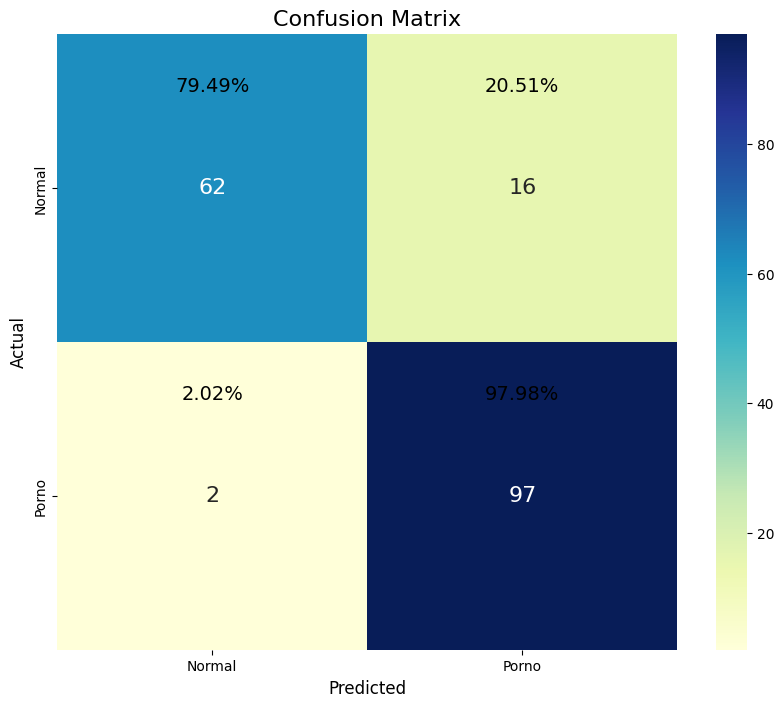

In [70]:
#v1 ta3 model
cm = confusion_matrix(trueLabels, predictions)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Generate a classification report
cr = classification_report(trueLabels, predictions, digits=4)
print("Classification Report:\n", cr)

# Calculate accuracy score
accuracy = accuracy_score(trueLabels, predictions)
print("Accuracy Score:", format(accuracy, '.4f'))

# Calculate F1 score
f1 = f1_score(trueLabels, predictions)
print("F1 Score:", format(f1, '.4f'))

# Plot the confusion matrix with annotations positioned at the bottom
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Normal', 'Porno'], yticklabels=['Normal', 'Porno'], annot_kws={'size': 16})

# Add custom annotations at the bottom of each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.2, '{:.2f}%'.format(cm_normalized[i, j] * 100), ha='center', va='bottom', color='black', fontsize=14)

plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [72]:
predictions,trueLabels=test_videos_pourcentage(r'A:\AI DB\LSPD\Videos\test\safe-easy',r'A:\AI DB\LSPD\Videos\test\porn',
                                               sensibility=0.98,
                                               threshold=0.15,
                                               percentage=1)

Processed 81/81 videos (100.00%)
Videos with mismatched results :
Video: porn_520.mp4, Predicted: 0, True Label: 1
Videos with no audio, couldn't read the audio successfully or too quiet :
Video: nonporn_415.mp4.
Video: nonporn_307.mp4.
Video: nonporn_146.mp4.
Video: nonporn_298.mp4.
Video: nonporn_560.mp4.
Video: nonporn_470.mp4.
Video: nonporn_445.mp4.
Video: nonporn_214.mp4.
Video: nonporn_457.mp4.
Video: nonporn_478.mp4.
Video: nonporn_228.mp4.
Video: nonporn_160.mp4.
Video: nonporn_314.mp4.
Video: nonporn_590.mp4.
Video: nonporn_552.mp4.
Video: nonporn_558.mp4.
Video: nonporn_127.mp4.
Video: nonporn_164.mp4.
Video: nonporn_29.mp4.
Video: nonporn_145.mp4.
Video: nonporn_373.mp4.
Video: nonporn_183.mp4.
Video: nonporn_16.mp4.
Video: nonporn_212.mp4.
Video: nonporn_411.mp4.
Video: nonporn_490.mp4.
Video: nonporn_536.mp4.
Video: nonporn_374.mp4.
Video: nonporn_338.mp4.
Video: nonporn_418.mp4.
Video: nonporn_175.mp4.
Video: porn_441.mp4.
Video: porn_145.mp4.
Video: porn_2.mp4.
Video: p

In [73]:
predictions,trueLabels=clear_none(predictions,trueLabels)

Classification Report:
               precision    recall  f1-score   support

           0     0.9167    1.0000    0.9565        11
           1     1.0000    0.9600    0.9796        25

    accuracy                         0.9722        36
   macro avg     0.9583    0.9800    0.9681        36
weighted avg     0.9745    0.9722    0.9725        36

Accuracy Score: 0.9722
F1 Score: 0.9796


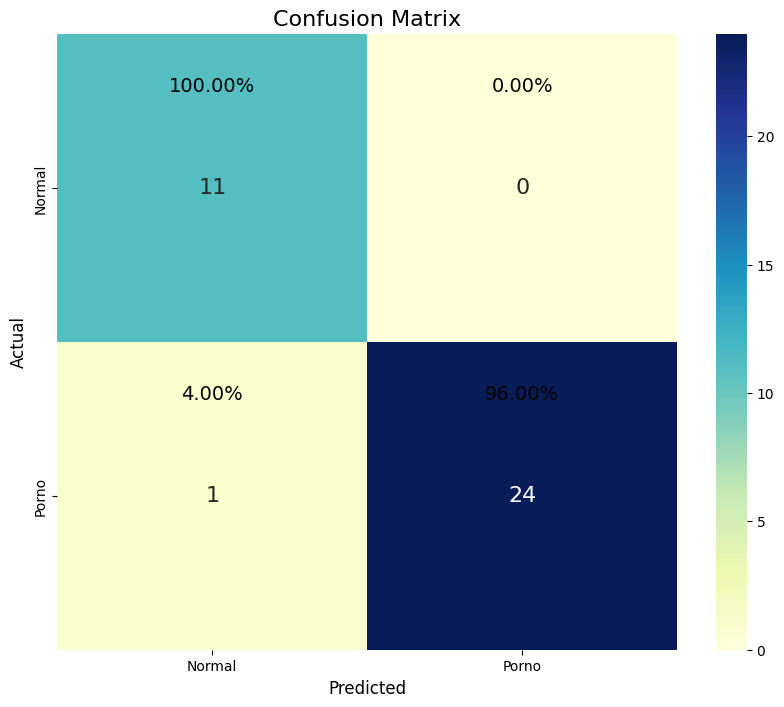

In [74]:
cm = confusion_matrix(trueLabels, predictions)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Generate a classification report
cr = classification_report(trueLabels, predictions, digits=4)
print("Classification Report:\n", cr)

# Calculate accuracy score
accuracy = accuracy_score(trueLabels, predictions)
print("Accuracy Score:", format(accuracy, '.4f'))

# Calculate F1 score
f1 = f1_score(trueLabels, predictions)
print("F1 Score:", format(f1, '.4f'))

# Plot the confusion matrix with annotations positioned at the bottom
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Normal', 'Porno'], yticklabels=['Normal', 'Porno'], annot_kws={'size': 16})

# Add custom annotations at the bottom of each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.2, '{:.2f}%'.format(cm_normalized[i, j] * 100), ha='center', va='bottom', color='black', fontsize=14)

plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [13]:
predictions,trueLabels=test_videos_pourcentage(r'A:\AI DB\LSPD\Videos\normal_final',r'A:\AI DB\LSPD\Videos\porn_final',
                                               sensibility=0.65,
                                               threshold=0.15,
                                               percentage=0.1)

Processed 400/400 videos (100.00%)
Videos with mismatched results :
Video: nonporn_1541.mp4, Predicted: 1, True Label: 0
Video: nonporn_1944.mp4, Predicted: 1, True Label: 0
Video: nonporn_1581.mp4, Predicted: 1, True Label: 0
Video: nonporn_11.mp4, Predicted: 1, True Label: 0
Video: nonporn_889.mp4, Predicted: 1, True Label: 0
Video: nonporn_1862.mp4, Predicted: 1, True Label: 0
Video: nonporn_56.mp4, Predicted: 1, True Label: 0
Video: nonporn_994.mp4, Predicted: 1, True Label: 0
Video: nonporn_395.mp4, Predicted: 1, True Label: 0
Video: nonporn_1843.mp4, Predicted: 1, True Label: 0
Video: nonporn_1384.mp4, Predicted: 1, True Label: 0
Video: nonporn_384.mp4, Predicted: 1, True Label: 0
Video: nonporn_1963.mp4, Predicted: 1, True Label: 0
Video: nonporn_1202.mp4, Predicted: 1, True Label: 0
Video: porn_1495.mp4, Predicted: 0, True Label: 1
Video: porn_1355.mp4, Predicted: 0, True Label: 1
Video: porn_953.mp4, Predicted: 0, True Label: 1
Video: porn_841.mp4, Predicted: 0, True Label: 1


In [12]:
timestamps=predict_audio_of_video(r'A:\AI DB\LSPD\Videos\porn_final\porn_22.mp4',sensibility=0.5,void_threshold=1)
print(timestamps)
if timestamps :
    print(len(timestamps))

Total time: 24.45 seconds.
Percentage of pornographic audio: 99.53%
[(0.0, 775.68)]
1


In [14]:
predictions,trueLabels=clear_none(predictions,trueLabels)

Classification Report:
               precision    recall  f1-score   support

           0     0.6489    0.8133    0.7219        75
           1     0.8783    0.7537    0.8112       134

    accuracy                         0.7751       209
   macro avg     0.7636    0.7835    0.7666       209
weighted avg     0.7960    0.7751    0.7792       209

Accuracy Score: 0.7751
F1 Score: 0.8112


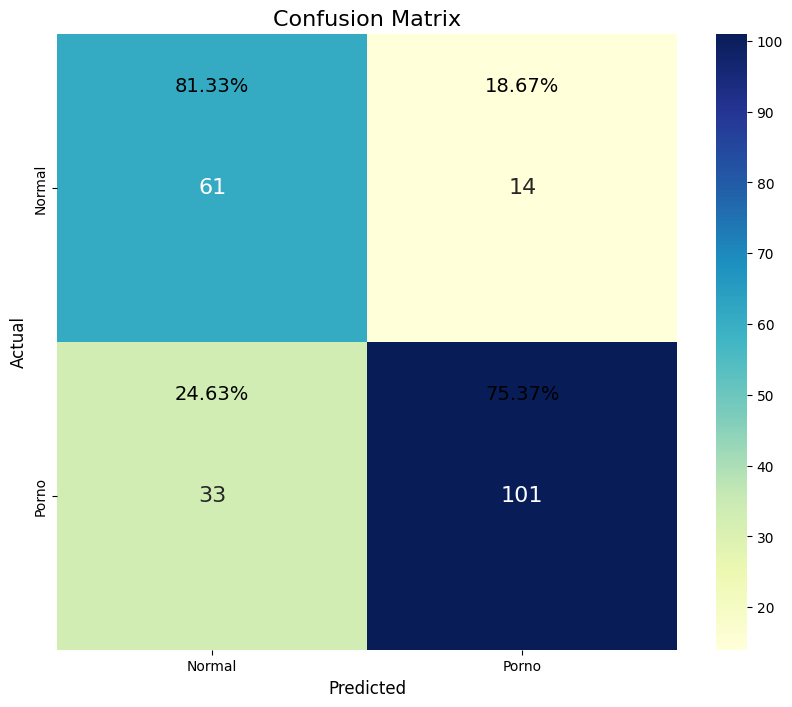

In [15]:
cm = confusion_matrix(trueLabels, predictions)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Generate a classification report
cr = classification_report(trueLabels, predictions, digits=4)
print("Classification Report:\n", cr)

# Calculate accuracy score
accuracy = accuracy_score(trueLabels, predictions)
print("Accuracy Score:", format(accuracy, '.4f'))

# Calculate F1 score
f1 = f1_score(trueLabels, predictions)
print("F1 Score:", format(f1, '.4f'))

# Plot the confusion matrix with annotations positioned at the bottom
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Normal', 'Porno'], yticklabels=['Normal', 'Porno'], annot_kws={'size': 16})

# Add custom annotations at the bottom of each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.2, '{:.2f}%'.format(cm_normalized[i, j] * 100), ha='center', va='bottom', color='black', fontsize=14)

plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()